# Rasterio & Numpy & Scipy

Some basic analysis techniques...  

Numpy and Scipy are both super useful for analyzing raster data once you're data is read as an array. Typically, a workflow would start with reading data with Rasterio, analyzing it with Numpy, Scipy, or something else, then writing it to an output file with Rasterio.  

**This is not a Numpy OR Scipy workshop!** We're just hitting some basics here... I'm just giving you some code so you get the idea and maybe whet your appetite.

Imports:

In [1]:
import rasterio as rio
from rasterio.plot import show
from matplotlib import pyplot as plt
import numpy as np
import scipy.ndimage
import os

Important: only run this once or you'll wind up in the wrong directory.
```python
os.chdir('../')
os.getcwd()
```

In [3]:
os.getcwd()

'C:\\Users\\phwh9568\\Workshops\\Rasterio'

### Slope  

We'll start by opening our DEM and reading it into an array:
```python
dem = rio.open('workshopdata/Flatirons_DEM_1m.tif')
demArray = dem.read(1)
```

In [4]:
dem = rio.open('workshopdata/dem.tif')
demArray = dem.read(1)

Take a peek at the meta:
```python
dem.meta
```

In [5]:
dem.meta

{'driver': 'GTiff',
 'dtype': 'int32',
 'nodata': 32767.0,
 'width': 639,
 'height': 646,
 'count': 1,
 'crs': CRS.from_epsg(3743),
 'transform': Affine(30.0, 0.0, 480578.7851666603,
        0.0, -30.0, 4500302.522612451)}

You'll need cell size to calculate slope...  

Remember that cell size is part of the affine transformation. (cell width, x origin, x origin coordinate, y origin, cell height, y origin coordinate)

```python
dem.transform
```

In [6]:
dem.transform

Affine(30.0, 0.0, 480578.7851666603,
       0.0, -30.0, 4500302.522612451)

We can use python's `assert` statement to check to see if the width and height are the same (or, well, close enough)...  

```python
assert (-dem.transform[4]-dem.transform[0]) < 0.00001
```

This would throw an error if the statement is not true.

In [7]:
assert(-dem.transform[4]-dem.transform[0]) < 0.00001

Okay cool. They're functionally the same, so we'll just use the cell width as the cell size, which is approximately 1m:  
```python
cellSize = dem.transform[0]
```

In [8]:
cellSize = dem.transform[0]

To calculate slope, first we'll need rise and run values for each cell. Fortunately, np.gradient can do this for us... Here are two explanations of how gradient works:  
https://numpy.org/doc/stable/reference/generated/numpy.gradient.html
https://stackoverflow.com/questions/24633618/what-does-numpy-gradient-do


```python
rise, run = np.gradient(demArray, cellSize)
```

In [9]:
rise, run = np.gradient(demArray, cellSize)

Now that you have change in elevation and change in linear distance, you have two parts of the Pythagorean Theorem... 

Time for good old Pythagorus:

```python
slope = np.sqrt(rise ** 2 + run**2)
```

In [10]:
slope = np.sqrt(rise **2 + run**2)

You can use np.arctan and np.degrees to get slope in degrees: 
```python
slope_deg = np.degrees(np.arctan(slope)).astype('int32')
```

In [19]:
slope_deg = np.degrees(np.arctan(slope)).astype('int32')

Let's take a look:

<AxesSubplot:>

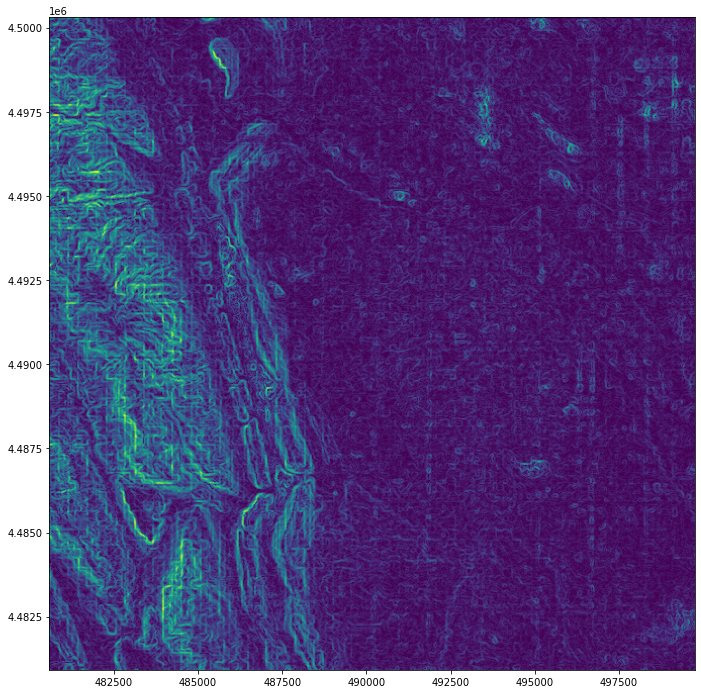

In [20]:
fig, ax = plt.subplots(1, figsize=(12,12))
show(slope_deg, transform = dem.transform, ax=ax)

In [21]:
profile = dem.profile
profile

{'driver': 'GTiff', 'dtype': 'int32', 'nodata': 32767.0, 'width': 639, 'height': 646, 'count': 1, 'crs': CRS.from_epsg(3743), 'transform': Affine(30.0, 0.0, 480578.7851666603,
       0.0, -30.0, 4500302.522612451), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'interleave': 'band'}

In [23]:
with rio.open('slope.tif', 'w', **profile) as slope_out:
    slope_out.write(slope_deg,1)

Save a little memory:

In [24]:
del dem, demArray, slope, slope_deg, rise, run, cellSize

We did not account for the edges of the image, but you get my drift... You can ask me later about that...   

#### NDVI  
That is Normalized Difference Vegetation Index, a measure of live green vegetation. You calculate NDVI by dividing the difference of the near infrared band and the red band by the sum of the near infrared band and the red band...  or:
NDVI = (NIR-R)/(NIR+R)

In Landsat 8, the red band is band 4, and the NIR band is band 5.


[Landsat 8 Bands](https://gisgeography.com/landsat-8-bands-combinations/)

Start by opening the red band and NIR band. This covers the Steamboat, CO vacinity:
```python
img_b4 = rio.open('workshopdata/LC08_Steamboat_B4.tif')
img_b5 = rio.open('workshopdata/LC08_Steamboat_B5.tif')
```

In [25]:
img_b4 = rio.open('workshopdata/LC08_Steamboat_B4.tif')
img_b5 = rio.open('workshopdata/LC08_Steamboat_B5.tif')

Take a peek at band 4:

<AxesSubplot:>

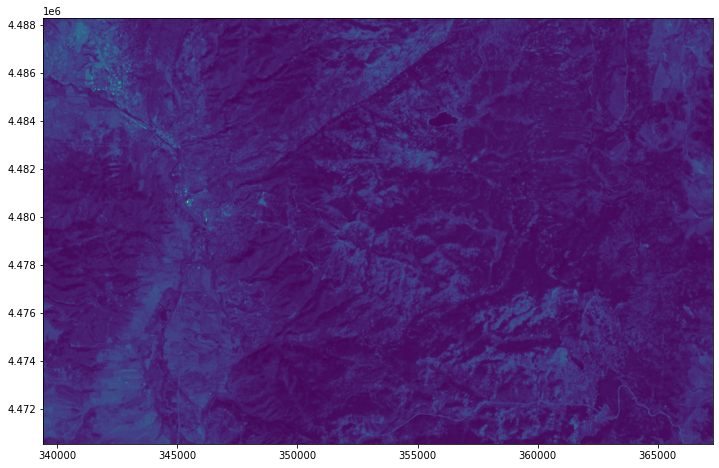

In [26]:
fig, ax = plt.subplots(1, figsize=(12,12))
show(img_b4, transform = img_b4.transform, ax=ax)

Read them as arrays:

In [27]:
b4 = img_b4.read(1)
b5 = img_b5.read(1)

Make sure the cell is square:

In [28]:
assert(-img_b4.transform[4]-img_b4.transform[0]) < 0.0001

It is... so grab the cell size as we did before:

In [29]:
cellSize = img_b4.transform[0]
print(cellSize)

30.0


NDVI is an index, meaning, the values exist between 0 and 1. We need to make sure the data hold decimal values, or in other words, we need to make sure they are float dtype. The data come as integer gype, so we must convert:

In [30]:
b5 = b5.astype(float).copy()
b4 = b4.astype(float).copy()

Now we'll apply the simple NDVI equation:

In [31]:
ndvi = (b5-b4)/(b4+b5)

Take a look:

<AxesSubplot:>

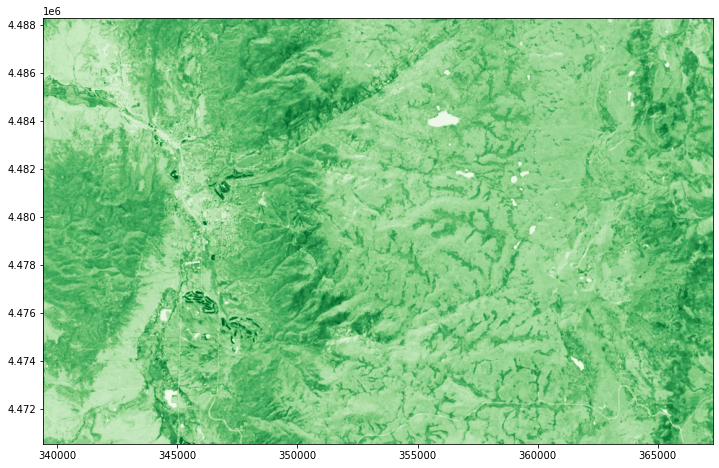

In [32]:
fig, ax = plt.subplots(1, figsize=(12,12))
show(ndvi, transform = img_b4.transform, ax=ax, cmap = 'Greens')

Save some memory, but we'll keep NDVI:

In [33]:
del img_b4, img_b5, b4, b5

### Zonal Stats:  

A common operation when you need to know how much of something (or other descriptive stats) fall within a certain a given area (zone).  

In this case, we'll find out NDVI summary values each landcover classification in the Steamboat vacinity. 

We'll bring in a landcover dataset, the [NLCD](https://www.mrlc.gov/data/legends/national-land-cover-database-class-legend-and-description). I've prepped this data so it's the exact same extent and CRS as the landsat data we just used.

In [34]:
nlcd = rio.open('workshopdata/NLCD_Steamboat.tif')

In case you're curious... 

<AxesSubplot:>

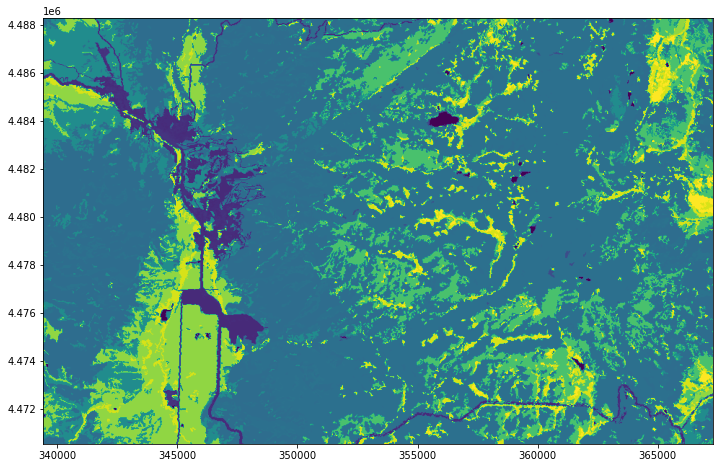

In [35]:
fig, ax = plt.subplots(1, figsize=(12,12))
show(nlcd, transform = nlcd.transform, ax=ax)

Read the NLCD data as an array:

In [36]:
nlcdArray = nlcd.read(1)

We'll need each unique value of the array... easy enough!

In [37]:
print(np.unique(nlcdArray))

[11 21 22 23 24 31 41 42 43 52 71 81 90 95]


We'll use those unique values as "bins", and we'll place them in a list:

In [38]:
bins = np.unique(nlcdArray)

Now, we'll create two empty lists that we'll iterate over, one which we'll add counts of each class, and the second where we'll sum counts of each class by bin... 

In [39]:
class_count = []
ndvi_nlcd = []

Now we'll iterate over the bins, and for the count, we'll sum the occurrence of cells of a particular class, then calculate the average NDVI value within all the cells of a given class:

In [40]:
for b in bins:
    count = np.sum(np.where(np.equal(nlcdArray,b),1,0))
    class_count.append(count)
    ndvi_nlcd.append(float(np.sum(np.where(np.equal(nlcdArray,b),ndvi,0)))/count)

Now a print statement so we can review the results:

In [41]:
for i in range(len(bins)):
    print('Class:',bins[i])
    print('Total cells in class:', class_count[i])
    print('NDVI within class:', ndvi_nlcd[i])
    print('*****************************')

Class: 11
Total cells in class: 1613
NDVI within class: 0.04111065117647047
*****************************
Class: 21
Total cells in class: 11154
NDVI within class: 0.23451557715488236
*****************************
Class: 22
Total cells in class: 6156
NDVI within class: 0.1812837712614419
*****************************
Class: 23
Total cells in class: 3022
NDVI within class: 0.13216947522797864
*****************************
Class: 24
Total cells in class: 851
NDVI within class: 0.08193704751912151
*****************************
Class: 31
Total cells in class: 669
NDVI within class: 0.11303103194658785
*****************************
Class: 41
Total cells in class: 146555
NDVI within class: 0.28436799269930113
*****************************
Class: 42
Total cells in class: 194498
NDVI within class: 0.19448791850131905
*****************************
Class: 43
Total cells in class: 9589
NDVI within class: 0.2547559684608169
*****************************
Class: 52
Total cells in class: 41796
NDVI wi

In [36]:
del nlcd, ndvi, nlcdArray

### Smoothing (mean) filter:

A mean filter is a focal (AKA neighborhood) operation where each cell is replaced with the average of the cell and it's eight neighbors. There are lot's of other focal operations. This can be done relatively easily with Numpy, but even easier with Scipy...  

Open up the DEM one more time and read it as an array:

In [42]:
dem = rio.open('workshopdata/dem.tif')
demArray = dem.read(1)

We'll use the uniform image filter from the Scipy NDimage module.

```python
demMean = scipy.ndimage.filters.uniform_filter(demArray, size=3)
```
Size refers to the size of the kernel, or moving window... in this case it is a 3 by 3 cell square, which would include every cell that touches a central cell...  

In [43]:
demMean = scipy.ndimage.filters.uniform_filter(demArray, size=3)

In [44]:
print('Original min:', demArray.min())
print('Original max:', demArray.max())
print('Original mean:', demArray.mean())
print('***********************')
print('New min:', demMean.min())
print('New max:', demMean.max())
print('new mean:', demMean.mean())

Original min: 1465
Original max: 2247
Original mean: 1617.633337693862
***********************
New min: 1467
New max: 2237
new mean: 1616.969326104546


Because none of the profile information changes, we can simply repurpose the original dem's profile metadata:

In [45]:
profile = dem.profile

In [46]:
with rio.open('demMean.tif', 'w', **profile) as demMean_out:
    demMean_out.write(demMean,1)

### Done! 